### Benchmark Models

In [2]:
# necessary modules
import pandas as pd
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm

from DataPreprocessing.preprocessing_function import preprocess_data
from benchmark_models import train_random_forest, train_lstm, train_rf_then_lstm
from shap_plots import plot_shap_values_RF, plot_shap_values_LSTM, plot_shap_values_RF_LSTM

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### JFK Models

In [3]:
# import dataset
merged_jfk_df = pd.read_csv('data/complete/JFK_final_df.csv')

# preprocessing
X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk = preprocess_data(merged_jfk_df)

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Train Accuracy: 0.8383
Train Precision: 0.7028
Train Recall: 0.8383
Train F1: 0.7646

Test Set Metrics:
Test Accuracy: 0.8244
Test Precision: 0.6796
Test Recall: 0.8244
Test F1: 0.7450


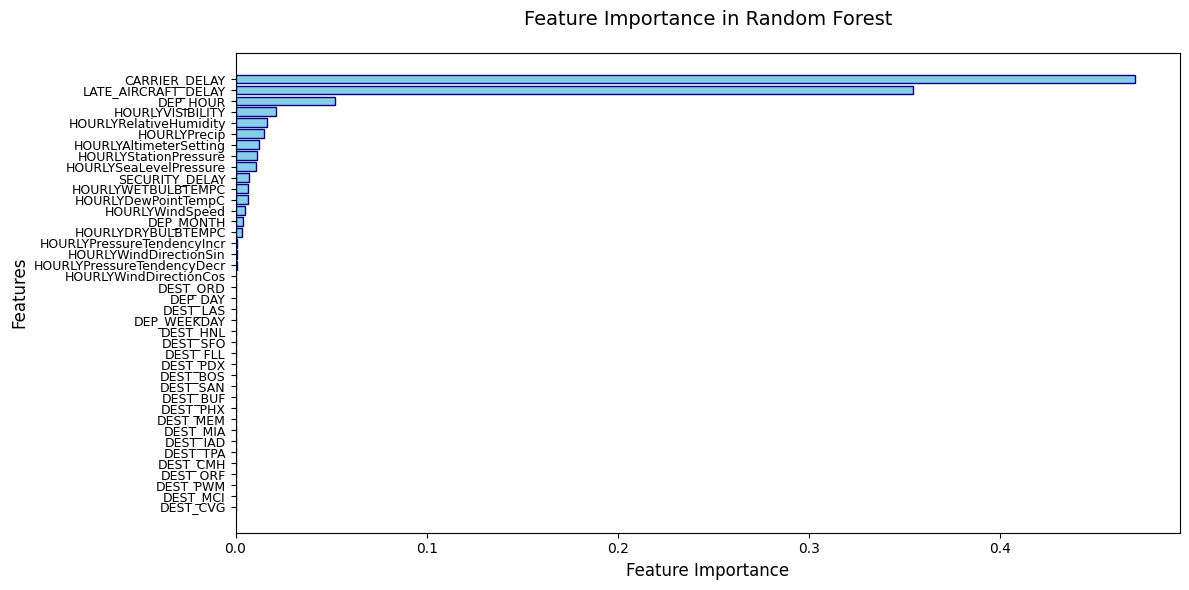

In [7]:
jfk_RF_model, jfk_metrics_RF = train_random_forest(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk)

Epoch [10/100], Loss: 0.2696, Accuracy: 0.9180
Epoch [20/100], Loss: 0.2618, Accuracy: 0.9196
Epoch [30/100], Loss: 0.2578, Accuracy: 0.9202
Epoch [40/100], Loss: 0.2554, Accuracy: 0.9208
Epoch [50/100], Loss: 0.2537, Accuracy: 0.9211
Epoch [60/100], Loss: 0.2523, Accuracy: 0.9215
Epoch [70/100], Loss: 0.2513, Accuracy: 0.9217
Epoch [80/100], Loss: 0.2504, Accuracy: 0.9220
Epoch [90/100], Loss: 0.2495, Accuracy: 0.9224
Epoch [100/100], Loss: 0.2490, Accuracy: 0.9223

Training Set Metrics:
Accuracy: 0.9232
Precision: 0.9152
Recall: 0.9232
F1-score: 0.9174

Test Set Metrics:
Accuracy: 0.9033
Precision: 0.8914
Recall: 0.9033
F1-score: 0.8956


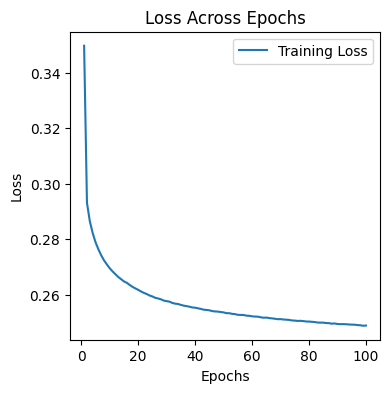

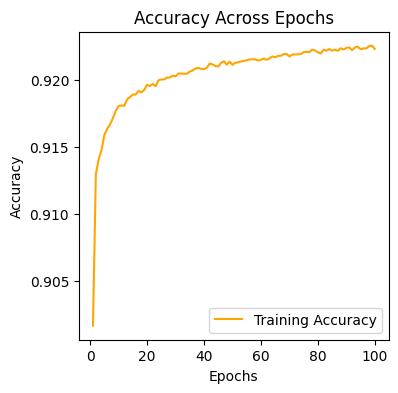

In [17]:
JFK_LSTM_model, JFK_metrics_LSTM = train_lstm(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk)

Epoch [10/100], Loss: 0.2929, Accuracy: 0.9159
Epoch [20/100], Loss: 0.2883, Accuracy: 0.9169
Epoch [30/100], Loss: 0.2859, Accuracy: 0.9175
Epoch [40/100], Loss: 0.2842, Accuracy: 0.9179
Epoch [50/100], Loss: 0.2831, Accuracy: 0.9182
Epoch [60/100], Loss: 0.2822, Accuracy: 0.9183
Epoch [70/100], Loss: 0.2815, Accuracy: 0.9183
Epoch [80/100], Loss: 0.2810, Accuracy: 0.9185
Epoch [90/100], Loss: 0.2805, Accuracy: 0.9186
Epoch [100/100], Loss: 0.2800, Accuracy: 0.9187

Training Set Metrics:
Accuracy: 0.9183
Precision: 0.9085
Recall: 0.9183
F1-score: 0.9119

Test Set Metrics:
Accuracy: 0.9072
Precision: 0.8952
Recall: 0.9072
F1-score: 0.8996


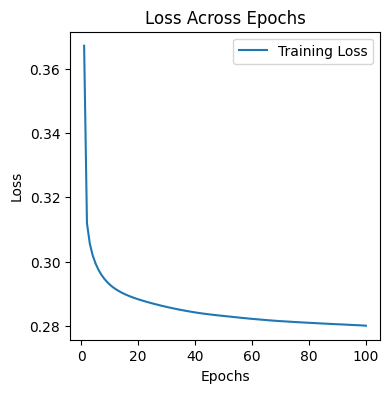

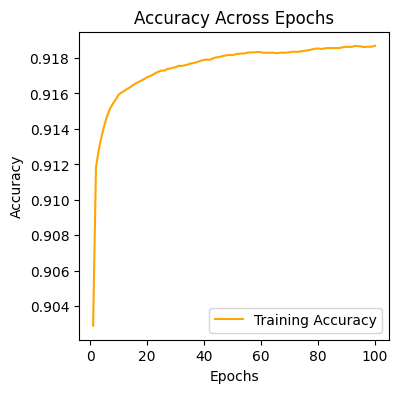

In [8]:
JFK_RFLSTM_model, JFK_metrics_RFLSTM, JFK_RF_features = train_rf_then_lstm(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk)

### Miami Models

In [4]:
# import dataset
merged_mia_df = pd.read_csv('data/complete/MIA_final_df.csv')

# preprocessing
X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia, feature_names_mia = preprocess_data(merged_mia_df)

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Train Accuracy: 0.8224
Train Precision: 0.6763
Train Recall: 0.8224
Train F1: 0.7422

Test Set Metrics:
Test Accuracy: 0.8331
Test Precision: 0.6940
Test Recall: 0.8331
Test F1: 0.7572


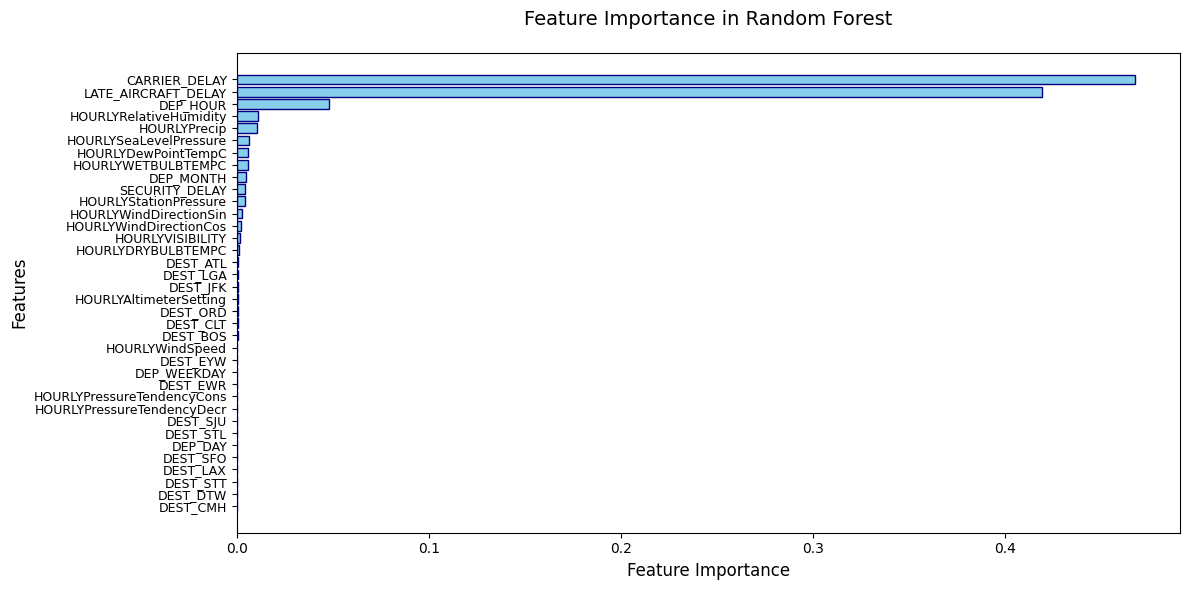

In [8]:
MIA_RF_model, MIA_metrics_RF = train_random_forest(X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia, feature_names_mia)

Epoch [10/100], Loss: 0.2730, Accuracy: 0.9192
Epoch [20/100], Loss: 0.2641, Accuracy: 0.9214
Epoch [30/100], Loss: 0.2590, Accuracy: 0.9222
Epoch [40/100], Loss: 0.2558, Accuracy: 0.9231
Epoch [50/100], Loss: 0.2536, Accuracy: 0.9238
Epoch [60/100], Loss: 0.2519, Accuracy: 0.9241
Epoch [70/100], Loss: 0.2504, Accuracy: 0.9246
Epoch [80/100], Loss: 0.2493, Accuracy: 0.9249
Epoch [90/100], Loss: 0.2483, Accuracy: 0.9251
Epoch [100/100], Loss: 0.2475, Accuracy: 0.9254

Training Set Metrics:
Accuracy: 0.9265
Precision: 0.9191
Recall: 0.9265
F1-score: 0.9216

Test Set Metrics:
Accuracy: 0.9063
Precision: 0.8934
Recall: 0.9063
F1-score: 0.8981


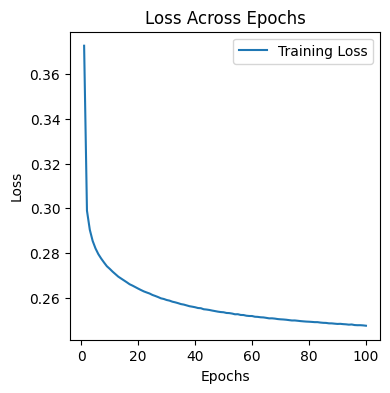

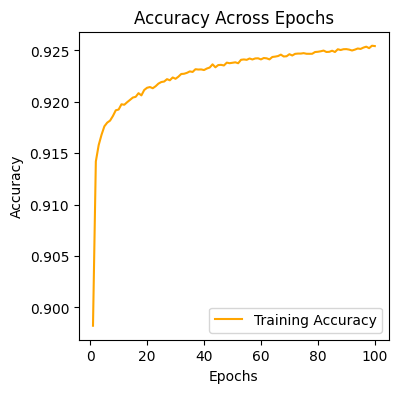

In [18]:
MIA_LSTM_model, MIA_metrics_LSTM = train_lstm(X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia)

Epoch [10/100], Loss: 0.2963, Accuracy: 0.9179
Epoch [20/100], Loss: 0.2908, Accuracy: 0.9190
Epoch [30/100], Loss: 0.2882, Accuracy: 0.9195
Epoch [40/100], Loss: 0.2865, Accuracy: 0.9199
Epoch [50/100], Loss: 0.2854, Accuracy: 0.9201
Epoch [60/100], Loss: 0.2845, Accuracy: 0.9202
Epoch [70/100], Loss: 0.2839, Accuracy: 0.9203
Epoch [80/100], Loss: 0.2833, Accuracy: 0.9203
Epoch [90/100], Loss: 0.2829, Accuracy: 0.9203
Epoch [100/100], Loss: 0.2824, Accuracy: 0.9205

Training Set Metrics:
Accuracy: 0.9197
Precision: 0.9102
Recall: 0.9197
F1-score: 0.9134

Test Set Metrics:
Accuracy: 0.9088
Precision: 0.8958
Recall: 0.9088
F1-score: 0.8999


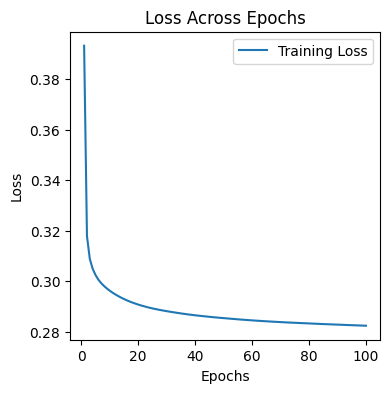

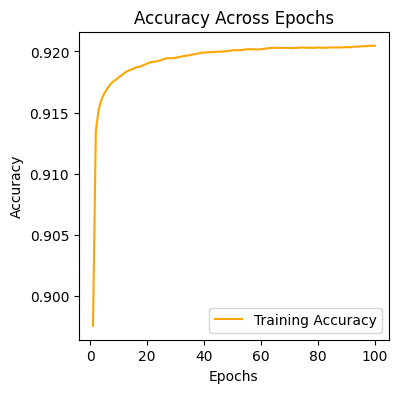

In [9]:
MIA_RFLSTM_model, MIA_metrics_RFLSTM, MIA_RF_features = train_rf_then_lstm(X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia, feature_names_mia)

### LAX Models

In [12]:
# import dataset
merged_lax_df = pd.read_csv('data/complete/LAX_final_df.csv')

# preprocessing
X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax, feature_names_lax = preprocess_data(merged_lax_df)

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Train Accuracy: 0.8446
Train Precision: 0.7134
Train Recall: 0.8446
Train F1: 0.7735

Test Set Metrics:
Test Accuracy: 0.8231
Test Precision: 0.6776
Test Recall: 0.8231
Test F1: 0.7433


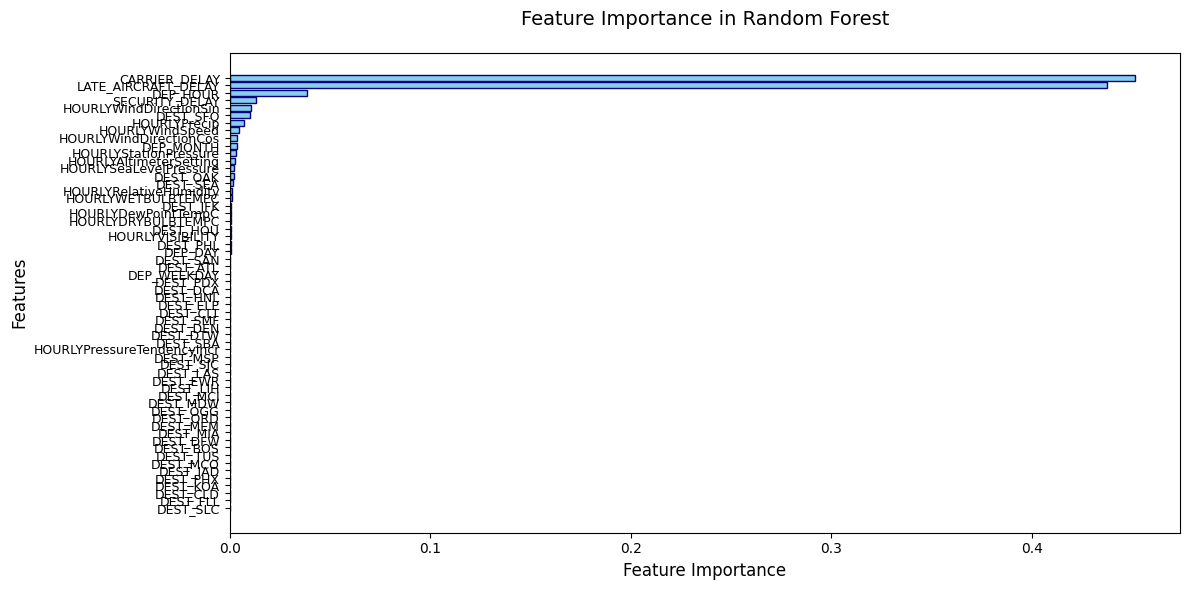

In [9]:
LAX_RF_model, LAX_metrics_RF = train_random_forest(X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax, feature_names_lax)

Epoch [10/100], Loss: 0.1947, Accuracy: 0.9417
Epoch [20/100], Loss: 0.1901, Accuracy: 0.9429
Epoch [30/100], Loss: 0.1880, Accuracy: 0.9434
Epoch [40/100], Loss: 0.1866, Accuracy: 0.9438
Epoch [50/100], Loss: 0.1858, Accuracy: 0.9440
Epoch [60/100], Loss: 0.1851, Accuracy: 0.9442
Epoch [70/100], Loss: 0.1847, Accuracy: 0.9444
Epoch [80/100], Loss: 0.1843, Accuracy: 0.9445
Epoch [90/100], Loss: 0.1841, Accuracy: 0.9447
Epoch [100/100], Loss: 0.1838, Accuracy: 0.9447

Training Set Metrics:
Accuracy: 0.9452
Precision: 0.9409
Recall: 0.9452
F1-score: 0.9422

Test Set Metrics:
Accuracy: 0.9190
Precision: 0.9116
Recall: 0.9190
F1-score: 0.9139


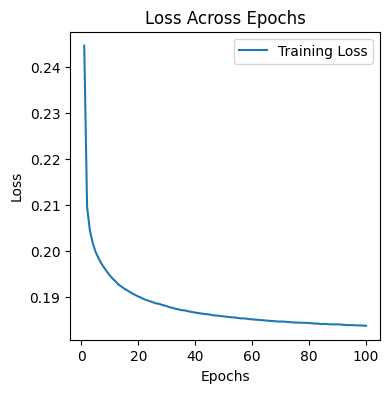

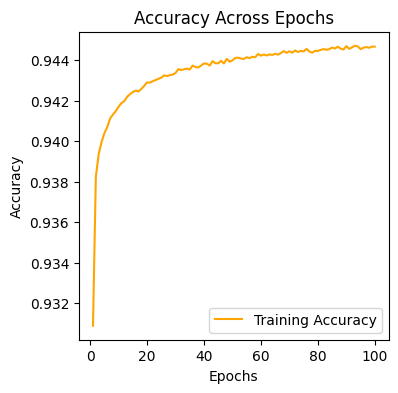

In [19]:
LAX_LSTM_model, LAX_metrics_LSTM = train_lstm(X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax)

Epoch [10/100], Loss: 0.2103, Accuracy: 0.9406
Epoch [20/100], Loss: 0.2071, Accuracy: 0.9413
Epoch [30/100], Loss: 0.2058, Accuracy: 0.9417
Epoch [40/100], Loss: 0.2049, Accuracy: 0.9419
Epoch [50/100], Loss: 0.2043, Accuracy: 0.9419
Epoch [60/100], Loss: 0.2039, Accuracy: 0.9420
Epoch [70/100], Loss: 0.2036, Accuracy: 0.9420
Epoch [80/100], Loss: 0.2033, Accuracy: 0.9421
Epoch [90/100], Loss: 0.2031, Accuracy: 0.9421
Epoch [100/100], Loss: 0.2029, Accuracy: 0.9421

Training Set Metrics:
Accuracy: 0.9421
Precision: 0.9373
Recall: 0.9421
F1-score: 0.9388

Test Set Metrics:
Accuracy: 0.9200
Precision: 0.9128
Recall: 0.9200
F1-score: 0.9148


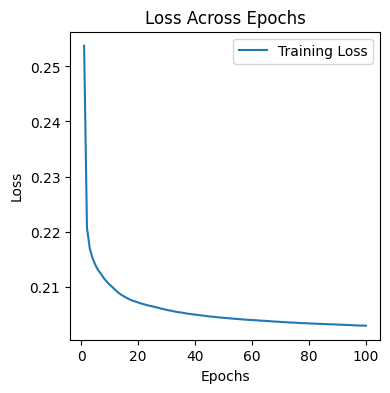

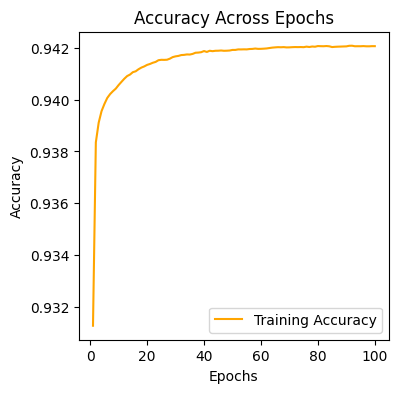

In [13]:
LAX_RFLSTM_model, LAX_metrics_RFLSTM, LAX_RF_features = train_rf_then_lstm(X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax, feature_names_lax)

### EWR Models

In [5]:
# import dataset
merged_ewr_df = pd.read_csv('data/complete/EWR_final_df.csv')

# preprocessing
X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr, feature_names_ewr = preprocess_data(merged_ewr_df)

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Train Accuracy: 0.8038
Train Precision: 0.6461
Train Recall: 0.8038
Train F1: 0.7164

Test Set Metrics:
Test Accuracy: 0.7947
Test Precision: 0.6316
Test Recall: 0.7947
Test F1: 0.7038


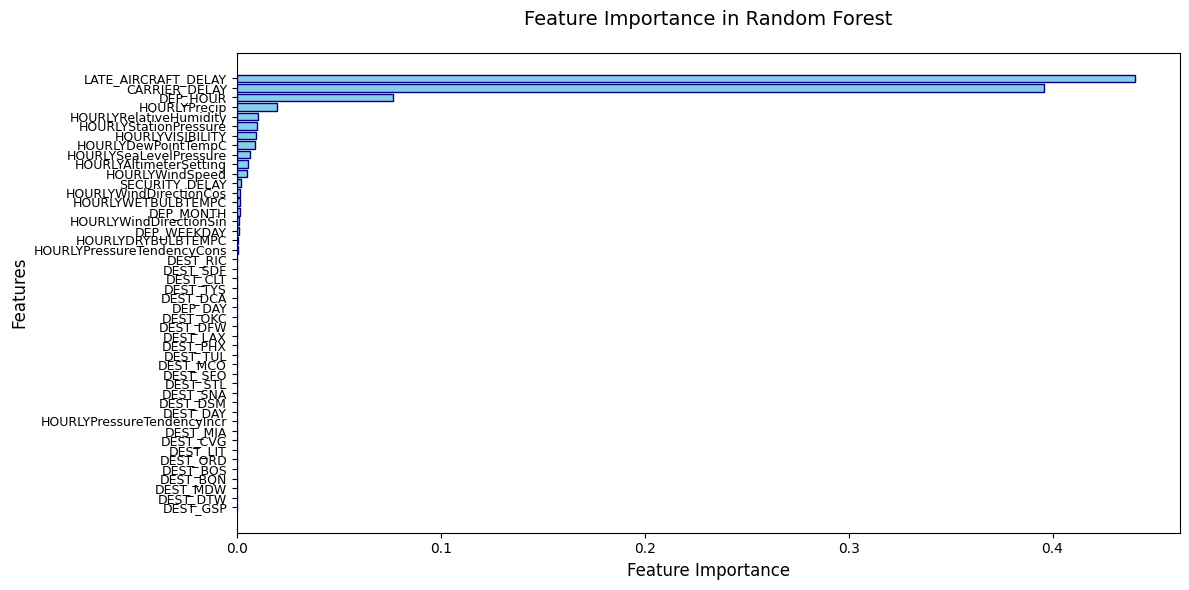

In [10]:
EWR_RF_model, EWR_metrics_RF = train_random_forest(X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr, feature_names_ewr)

Epoch [10/100], Loss: 0.2906, Accuracy: 0.9072
Epoch [20/100], Loss: 0.2825, Accuracy: 0.9095
Epoch [30/100], Loss: 0.2783, Accuracy: 0.9105
Epoch [40/100], Loss: 0.2756, Accuracy: 0.9113
Epoch [50/100], Loss: 0.2736, Accuracy: 0.9117
Epoch [60/100], Loss: 0.2722, Accuracy: 0.9122
Epoch [70/100], Loss: 0.2710, Accuracy: 0.9125
Epoch [80/100], Loss: 0.2702, Accuracy: 0.9127
Epoch [90/100], Loss: 0.2694, Accuracy: 0.9132
Epoch [100/100], Loss: 0.2688, Accuracy: 0.9132

Training Set Metrics:
Accuracy: 0.9143
Precision: 0.9073
Recall: 0.9143
F1-score: 0.9094

Test Set Metrics:
Accuracy: 0.8925
Precision: 0.8832
Recall: 0.8925
F1-score: 0.8866


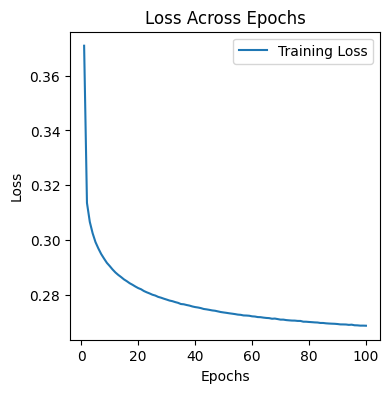

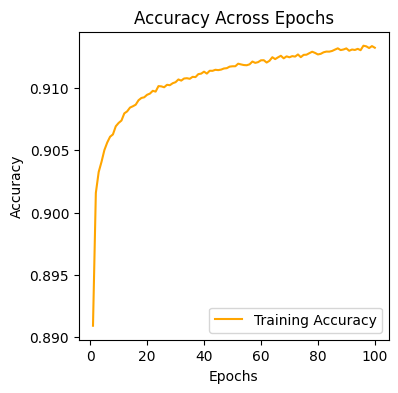

In [20]:
EWR_LSTM_model, EWR_metrics_LSTM = train_lstm(X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr)

Epoch [10/100], Loss: 0.3092, Accuracy: 0.9052
Epoch [20/100], Loss: 0.3045, Accuracy: 0.9066
Epoch [30/100], Loss: 0.3019, Accuracy: 0.9071
Epoch [40/100], Loss: 0.3003, Accuracy: 0.9076
Epoch [50/100], Loss: 0.2991, Accuracy: 0.9079
Epoch [60/100], Loss: 0.2983, Accuracy: 0.9080
Epoch [70/100], Loss: 0.2976, Accuracy: 0.9082
Epoch [80/100], Loss: 0.2971, Accuracy: 0.9083
Epoch [90/100], Loss: 0.2966, Accuracy: 0.9084
Epoch [100/100], Loss: 0.2963, Accuracy: 0.9085

Training Set Metrics:
Accuracy: 0.9082
Precision: 0.9000
Recall: 0.9082
F1-score: 0.9025

Test Set Metrics:
Accuracy: 0.8985
Precision: 0.8900
Recall: 0.8985
F1-score: 0.8926


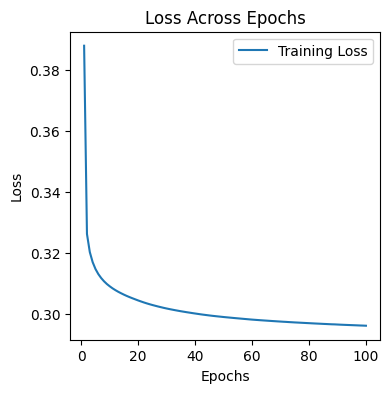

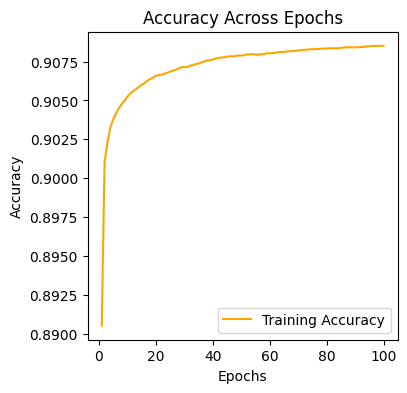

In [14]:
EWR_RFLSTM_model, EWR_metrics_RFLSTM, EWR_RF_features = train_rf_then_lstm(X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr, feature_names_ewr)

### ORD Models

In [6]:
# import dataset
merged_ord_df = pd.read_csv('data/complete/ORD_final_df.csv')

# preprocessing
X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord, feature_names_ord = preprocess_data(merged_ord_df)

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Train Accuracy: 0.7931
Train Precision: 0.6290
Train Recall: 0.7931
Train F1: 0.7016

Test Set Metrics:
Test Accuracy: 0.8258
Test Precision: 0.6819
Test Recall: 0.8258
Test F1: 0.7470


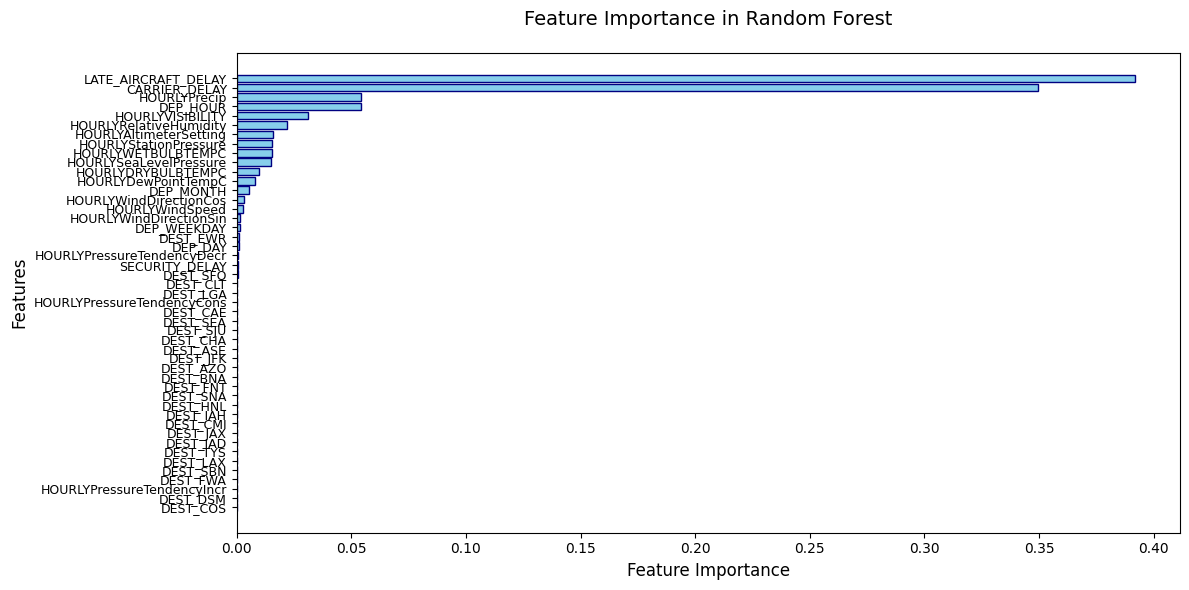

In [11]:
ORD_RF_model, ORD_metrics_RF = train_random_forest(X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord, feature_names_ord)

Epoch [10/100], Loss: 0.3093, Accuracy: 0.9073
Epoch [20/100], Loss: 0.3041, Accuracy: 0.9083
Epoch [30/100], Loss: 0.3016, Accuracy: 0.9088
Epoch [40/100], Loss: 0.3002, Accuracy: 0.9091
Epoch [50/100], Loss: 0.2991, Accuracy: 0.9093
Epoch [60/100], Loss: 0.2984, Accuracy: 0.9095
Epoch [70/100], Loss: 0.2979, Accuracy: 0.9096
Epoch [80/100], Loss: 0.2974, Accuracy: 0.9098
Epoch [90/100], Loss: 0.2970, Accuracy: 0.9100
Epoch [100/100], Loss: 0.2967, Accuracy: 0.9099

Training Set Metrics:
Accuracy: 0.9106
Precision: 0.9018
Recall: 0.9106
F1-score: 0.9049

Test Set Metrics:
Accuracy: 0.9164
Precision: 0.9076
Recall: 0.9164
F1-score: 0.9110


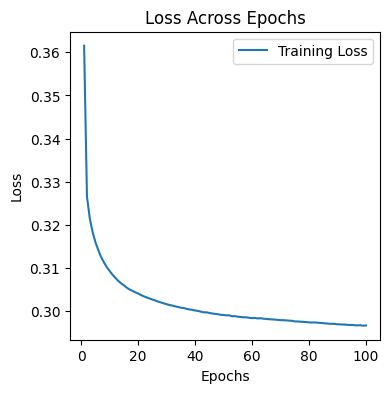

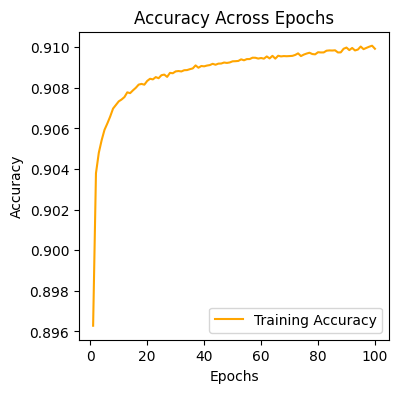

In [7]:
ORD_LSTM_model, ORD_metrics_LSTM = train_lstm(X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord)

Epoch [10/100], Loss: 0.3282, Accuracy: 0.9062
Epoch [20/100], Loss: 0.3249, Accuracy: 0.9070
Epoch [30/100], Loss: 0.3235, Accuracy: 0.9073
Epoch [40/100], Loss: 0.3227, Accuracy: 0.9073
Epoch [50/100], Loss: 0.3220, Accuracy: 0.9074
Epoch [60/100], Loss: 0.3215, Accuracy: 0.9076
Epoch [70/100], Loss: 0.3212, Accuracy: 0.9076
Epoch [80/100], Loss: 0.3209, Accuracy: 0.9076
Epoch [90/100], Loss: 0.3206, Accuracy: 0.9077
Epoch [100/100], Loss: 0.3205, Accuracy: 0.9076

Training Set Metrics:
Accuracy: 0.9050
Precision: 0.8943
Recall: 0.9050
F1-score: 0.8983

Test Set Metrics:
Accuracy: 0.9181
Precision: 0.9086
Recall: 0.9181
F1-score: 0.9122


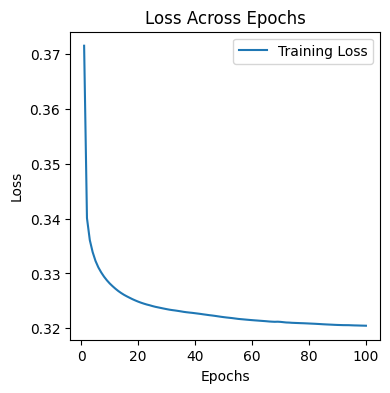

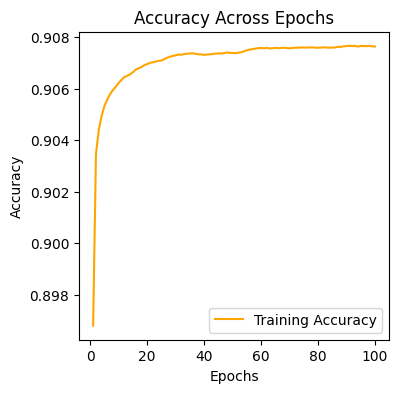

In [16]:
ORD_RFLSTM_model, ORD_metrics_RFLSTM, ORD_RF_features = train_rf_then_lstm(X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord, feature_names_ord)

### SHAP Analysis for Benchmarks

Random Forest

In [12]:
# jfk
plot_shap_values_RF(jfk_RF_model, X_train_torch_jfk, X_test_torch_jfk, feature_names_jfk, 'jfk', 'RF_shap_jfk.png', sample_size=2000)

Random Forest SHAP summary plot generated and saved as 'RF_shap_jfk.png' for JFK (Sampled 2000 points)


In [13]:
# mia
plot_shap_values_RF(MIA_RF_model, X_train_torch_mia, X_test_torch_mia, feature_names_mia, 'mia', 'RF_shap_mia.png', sample_size=2000)

Random Forest SHAP summary plot generated and saved as 'RF_shap_mia.png' for MIA (Sampled 2000 points)


In [14]:
# lax
plot_shap_values_RF(LAX_RF_model, X_train_torch_lax, X_test_torch_lax, feature_names_lax, 'lax', 'RF_shap_lax.png', sample_size=2000)

Random Forest SHAP summary plot generated and saved as 'RF_shap_lax.png' for LAX (Sampled 2000 points)


In [15]:
# ewr
plot_shap_values_RF(EWR_RF_model, X_train_torch_ewr, X_test_torch_ewr, feature_names_ewr, 'ewr', 'RF_shap_ewr.png', sample_size=2000)

Random Forest SHAP summary plot generated and saved as 'RF_shap_ewr.png' for EWR (Sampled 2000 points)


In [16]:
# ord
plot_shap_values_RF(ORD_RF_model, X_train_torch_ord, X_test_torch_ord, feature_names_ord, 'ord', 'RF_shap_ord.png', sample_size=2000)

Random Forest SHAP summary plot generated and saved as 'RF_shap_ord.png' for ORD (Sampled 2000 points)


LSTM

In [22]:
# jfk
plot_shap_values_LSTM(JFK_LSTM_model, X_train_torch_jfk, X_test_torch_jfk, feature_names_jfk, 'jfk', save_path="LSTM_shap_jfk.png", sample_size=500, background_size=50)

Computing SHAP values: 100%|██████████| 500/500 [10:20<00:00,  1.24s/sample]


shap_values_sample shape: (500, 1, 102, 13)
X_sample shape: (500, 102)
SHAP summary plot generated and saved as 'LSTM_shap_jfk.png' for JFK (Sampled 500 points)


In [23]:
# mia
plot_shap_values_LSTM(MIA_LSTM_model, X_train_torch_mia, X_test_torch_mia, feature_names_mia, 'mia', save_path='LSTM_shap_mia.png', sample_size=500, background_size=50)

Computing SHAP values: 100%|██████████| 500/500 [05:09<00:00,  1.62sample/s]


shap_values_sample shape: (500, 1, 89, 13)
X_sample shape: (500, 89)
SHAP summary plot generated and saved as 'LSTM_shap_mia.png' for MIA (Sampled 500 points)


In [24]:
# lax
plot_shap_values_LSTM(LAX_LSTM_model, X_train_torch_lax, X_test_torch_lax, feature_names_lax, 'lax', save_path='LSTM_shap_lax.png', sample_size=500, background_size=50)

Computing SHAP values: 100%|██████████| 500/500 [05:43<00:00,  1.46sample/s]


shap_values_sample shape: (500, 1, 139, 13)
X_sample shape: (500, 139)
SHAP summary plot generated and saved as 'LSTM_shap_lax.png' for LAX (Sampled 500 points)


In [25]:
# ewr
plot_shap_values_LSTM(EWR_LSTM_model,X_train_torch_ewr, X_test_torch_ewr, feature_names_ewr, 'ewr', save_path='LSTM_shap_ewr.png', sample_size=500, background_size=50)

Computing SHAP values: 100%|██████████| 500/500 [06:08<00:00,  1.36sample/s]


shap_values_sample shape: (500, 1, 123, 13)
X_sample shape: (500, 123)
SHAP summary plot generated and saved as 'LSTM_shap_ewr.png' for EWR (Sampled 500 points)


In [11]:
# ord
plot_shap_values_LSTM(ORD_LSTM_model, X_train_torch_ord, X_test_torch_ord, feature_names_ord, 'ord', save_path='LSTM_shap_ord.png', sample_size=500, background_size=50)

Computing SHAP values: 100%|██████████| 500/500 [06:55<00:00,  1.20sample/s]


shap_values_sample shape: (500, 1, 208, 13)
X_sample shape: (500, 208)
SHAP summary plot generated and saved as 'LSTM_shap_ord.png' for ORD (Sampled 500 points)


RF + LSTM

Computing SHAP values: 100%|██████████| 500/500 [02:18<00:00,  3.62sample/s]


shap_values_sample shape: (500, 1, 10, 13)
X_sample shape: (500, 10)


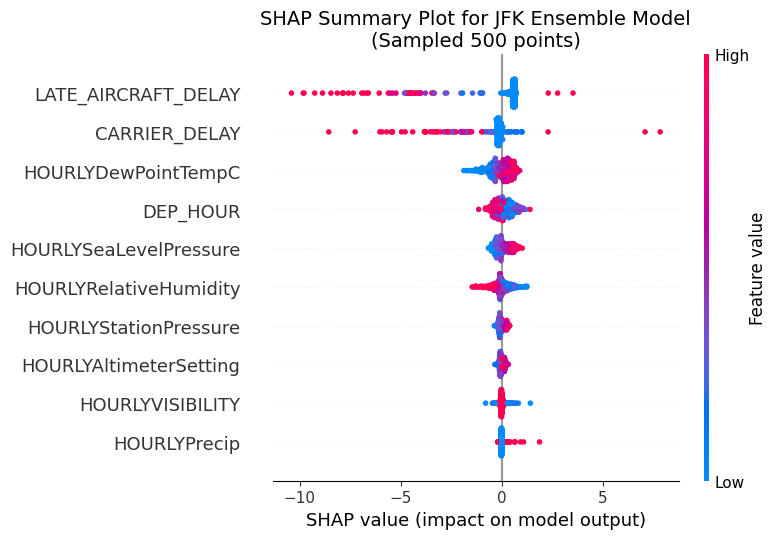

RF-LSTM SHAP summary plot generated and saved as 'RFLSTM_shap_jfk.png' for JFK (Sampled 500 points)


In [23]:
# jfk
# indices of the selected features
top_feature_indices_jfk = [feature_names_jfk.index(feat) for feat in JFK_RF_features]

# reduced datasets that were used to train the LSTM
X_train_selected_jfk = X_train_torch_jfk[:, top_feature_indices_jfk]
X_test_selected_jfk = X_test_torch_jfk[:, top_feature_indices_jfk]

# reduced datasets with SHAP function
plot_shap_values_RF_LSTM(JFK_RFLSTM_model, 
                         X_train_selected_jfk,  # The reduced training set
                         X_test_selected_jfk,   # The reduced test set
                         JFK_RF_features,   # The selected feature names
                         'jfk',
                         save_path="RFLSTM_shap_jfk.png")

Computing SHAP values: 100%|██████████| 500/500 [01:44<00:00,  4.80sample/s]


shap_values_sample shape: (500, 1, 10, 13)
X_sample shape: (500, 10)


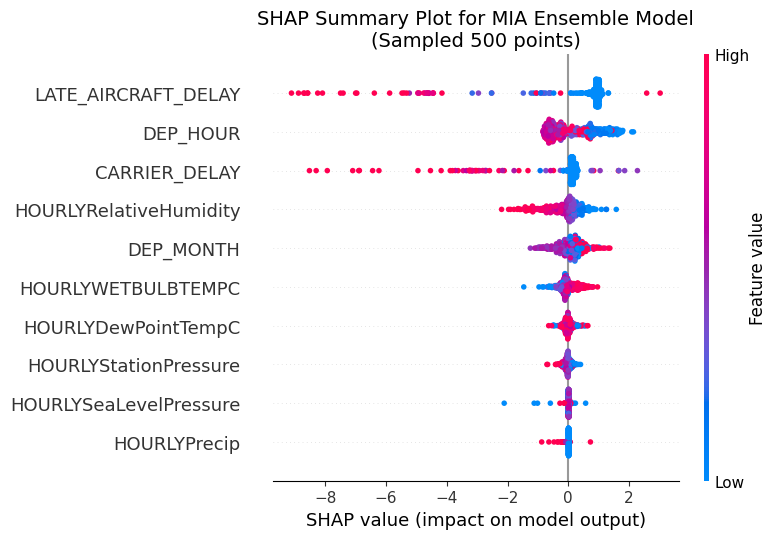

RF-LSTM SHAP summary plot generated and saved as 'RFLSTM_shap_mia.png' for MIA (Sampled 500 points)


In [19]:
# mia
# indices of the selected features
top_feature_indices_mia = [feature_names_mia.index(feat) for feat in MIA_RF_features]

# reduced datasets that were used to train the LSTM
X_train_selected_mia = X_train_torch_mia[:, top_feature_indices_mia]
X_test_selected_mia = X_test_torch_mia[:, top_feature_indices_mia]

# reduced datasets with SHAP function
plot_shap_values_RF_LSTM(MIA_RFLSTM_model,
                         X_train_selected_mia,  # The reduced training set
                         X_test_selected_mia,   # The reduced test set
                         MIA_RF_features,   # The selected feature names
                        'mia',
                        save_path="RFLSTM_shap_mia.png")

Computing SHAP values: 100%|██████████| 500/500 [00:57<00:00,  8.68sample/s]


shap_values_sample shape: (500, 1, 10, 13)
X_sample shape: (500, 10)


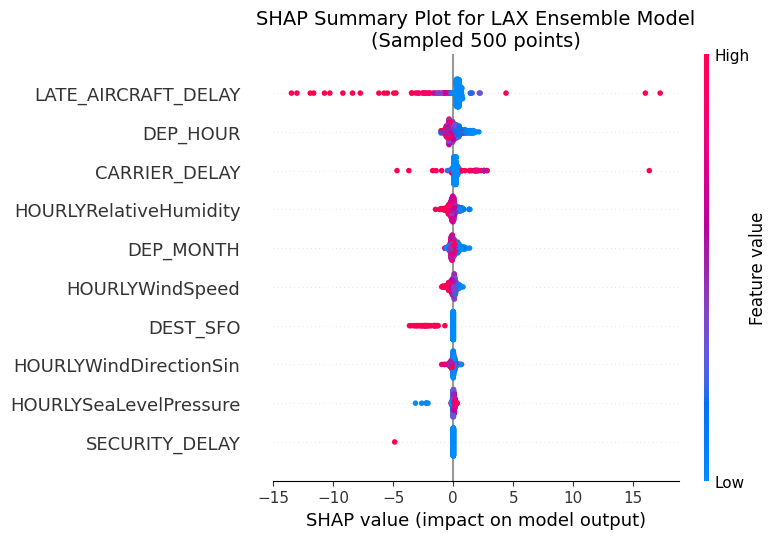

RF-LSTM SHAP summary plot generated and saved as 'RFLSTM_shap_lax.png' for LAX (Sampled 500 points)


In [20]:
# lax
# indices of the selected features
top_feature_indices_lax = [feature_names_lax.index(feat) for feat in LAX_RF_features]

# reduced datasets that were used to train the LSTM
X_train_selected_lax = X_train_torch_lax[:, top_feature_indices_lax]
X_test_selected_lax = X_test_torch_lax[:, top_feature_indices_lax]

# reduced datasets with SHAP function
plot_shap_values_RF_LSTM(LAX_RFLSTM_model,
                         X_train_selected_lax,  # The reduced training set
                         X_test_selected_lax,   # The reduced test set
                         LAX_RF_features,   # The selected feature names
                        'lax',
                        save_path="RFLSTM_shap_lax.png")

Computing SHAP values: 100%|██████████| 500/500 [36:05<00:00,  4.33s/sample]


shap_values_sample shape: (500, 1, 10, 13)
X_sample shape: (500, 10)


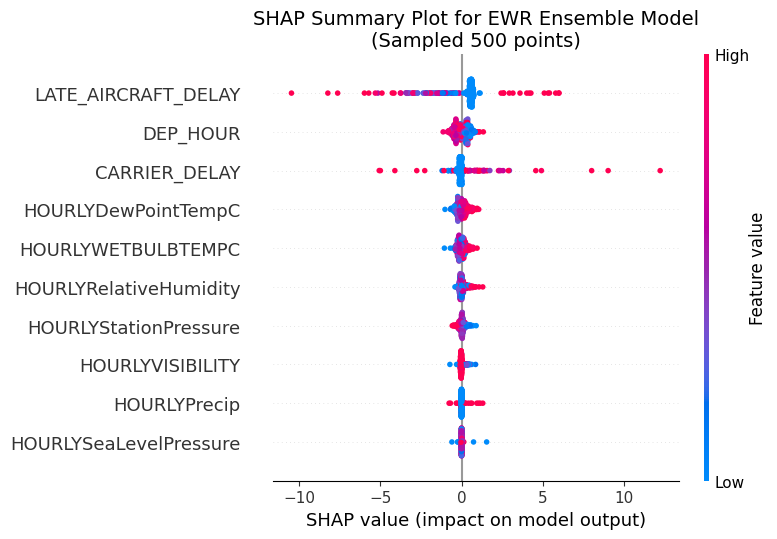

RF-LSTM SHAP summary plot generated and saved as 'RFLSTM_shap_ewr.png' for EWR (Sampled 500 points)


In [21]:
# ewr
# indices of the selected features
top_feature_indices_ewr = [feature_names_ewr.index(feat) for feat in EWR_RF_features]

# reduced datasets that were used to train the LSTM
X_train_selected_ewr = X_train_torch_ewr[:, top_feature_indices_ewr]
X_test_selected_ewr = X_test_torch_ewr[:, top_feature_indices_ewr]

# reduced datasets with SHAP function
plot_shap_values_RF_LSTM(EWR_RFLSTM_model,
                         X_train_selected_ewr,  # The reduced training set
                         X_test_selected_ewr,   # The reduced test set
                         EWR_RF_features,   # The selected feature names
                        'ewr',
                        save_path="RFLSTM_shap_ewr.png")

Computing SHAP values: 100%|██████████| 500/500 [01:56<00:00,  4.31sample/s]


shap_values_sample shape: (500, 1, 10, 13)
X_sample shape: (500, 10)


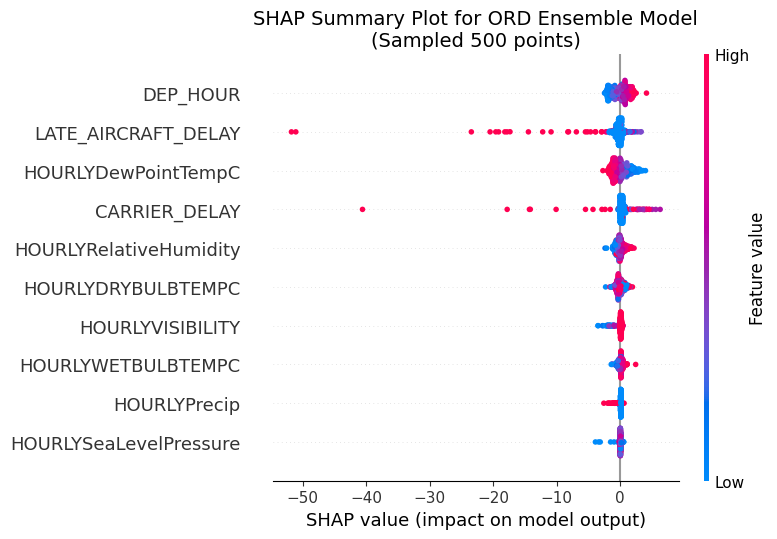

RF-LSTM SHAP summary plot generated and saved as 'RFLSTM_shap_ord.png' for ORD (Sampled 500 points)


In [22]:
# ord
# indices of the selected features
top_feature_indices_ord = [feature_names_ord.index(feat) for feat in ORD_RF_features]

# reduced datasets that were used to train the LSTM
X_train_selected_ord = X_train_torch_ord[:, top_feature_indices_ord]
X_test_selected_ord = X_test_torch_ord[:, top_feature_indices_ord]

# reduced datasets with SHAP function
plot_shap_values_RF_LSTM(ORD_RFLSTM_model,
                         X_train_selected_ord,  # The reduced training set
                         X_test_selected_ord,   # The reduced test set
                         ORD_RF_features,   # The selected feature names
                        'ord',
                        save_path="RFLSTM_shap_ord.png")